# 2. Time Series Clustering

* Initially thought I would use 1 RNN based model for making predictions
    * But in order to do this I would have to onehot encode the meter_id's (as ordinal would apply a linear relation between id's which doesn't exist)
        * This would add an extra 3500 features and hence make the solution space sufficiently sparse that it is likely our model would give any sort of reasonable performance
        
* My next thought was that instead I could create a separate RNN based model for each of the meters
    * Issue is the time complexity of doing so: even if each model only takes 1 minute to run (of which it is likely they will take longer) that would be 2.4 days of continuous computation
        * And this would have to be repeated for hyperparameter tuning and changes to the model and methodology
            * Very impractical especially considering time constraint of the competition
            
* My plan is to compromise between the 2 by clustering similar time series patterns and having a separate model for making predictions for each of the similar patterns
    * May still have problems with the size of the onehot encoded variables
    * Will also have problem with missing variables as will soon see
    
* If this proves impractical will instead consider models which can better handle categorical values such as decision tree based methods
    * LGB
    * XGBoost
    * Etc.
    
# Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from tqdm.notebook import tqdm
from tslearn.clustering import TimeSeriesKMeans
from yellowbrick.cluster import KElbowVisualizer

In C:\Users\psydm7\Anaconda3\envs\mle_tf\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\psydm7\Anaconda3\envs\mle_tf\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\psydm7\Anaconda3\envs\mle_tf\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In C:\Users\psydm7\Anaconda3\envs\mle_tf\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\psydm7\Anaconda3\envs\mle_tf

# pd display options

In [ ]:
pd.set_option('display.max_rows', 20)
pd.set_option('display.max_columns', 20)

#  Loading the data

In [2]:
df_energy = pd.read_pickle("../Data/Preprocessed_Data/consumption_daily_nan_interpolated.pkl")

In [6]:
df_energy

,meter_id,2017-01-01,2017-01-02,2017-01-03,2017-01-04,2017-01-05,2017-01-06,2017-01-07,2017-01-08,2017-01-09,...,2017-12-22,2017-12-23,2017-12-24,2017-12-25,2017-12-26,2017-12-27,2017-12-28,2017-12-29,2017-12-30,2017-12-31
0,0xa62b9f23553ff183f61e2bf943aab3d5983d02d7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,4.030,5.397,5.1075,4.818,3.931,4.2170,4.503,4.8160,5.129,5.395
1,0x459c834d1f6cfb5b734b82aa9f5410fa97fb70da,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,13.101,14.327,14.6315,14.936,16.174,20.3960,24.618,19.8925,15.167,11.751
2,0x4a1ed36825360a058cec2bdd409fc2459e1ce54f,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,10.201,7.320,7.3520,7.384,14.425,16.0650,17.705,13.3355,8.966,4.633
3,0x5b76d3c0e0aefc6e0a8d1d031f96388a23263407,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,14.833,12.477,11.7255,10.974,19.646,21.8195,23.993,19.9170,15.841,14.452
4,0x943ebe39ef2be6ef807c42c5a647e27112ca5b0f,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,39.440,35.538,21.9445,8.351,9.957,17.9140,25.871,36.0725,46.274,16.901
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3243,0x7dd7a7b8ee1bec7c44b24f738c752482f6161065,2.317,2.301,2.352,2.516,2.229,2.354,2.397,2.397,2.269,...,9.390,9.231,9.2235,9.216,9.336,9.6840,10.032,9.8945,9.757,9.480
3244,0xfdaf9f857621ec06f2cf801f42a020a322835090,14.437,16.274,7.031,17.018,17.603,15.005,8.987,8.490,10.136,...,4.141,2.828,3.8230,4.818,3.357,8.1315,12.906,8.0140,3.122,3.401
3245,0xd28f2f001e0cd4d6c121a3cb2e1427207e170e18,7.824,7.517,5.398,6.788,7.360,6.898,7.321,8.042,8.207,...,6.767,5.919,5.9980,6.077,7.761,6.6080,5.455,5.5670,5.679,8.148
3246,0x47218b46abb2fcaade487a211911406dc6e13730,23.965,28.689,27.664,29.229,29.548,27.909,26.923,21.277,23.452,...,20.747,19.979,20.1925,20.406,23.668,27.7900,31.912,29.1125,26.313,24.201


# Looking at how many missing values we have

In [4]:
# how many nans do we have
nan_count = df_energy.drop("meter_id", axis=1).isnull().sum(axis = 0)
nan_count

2017-01-01    2983
2017-01-02    2980
2017-01-03    2980
2017-01-04    2980
2017-01-05    2980
              ... 
2017-12-27      10
2017-12-28      10
2017-12-29      10
2017-12-30      10
2017-12-31      10
Length: 365, dtype: int64

<AxesSubplot:title={'center':'Missing values per day'}, xlabel='date', ylabel='number of missing values'>

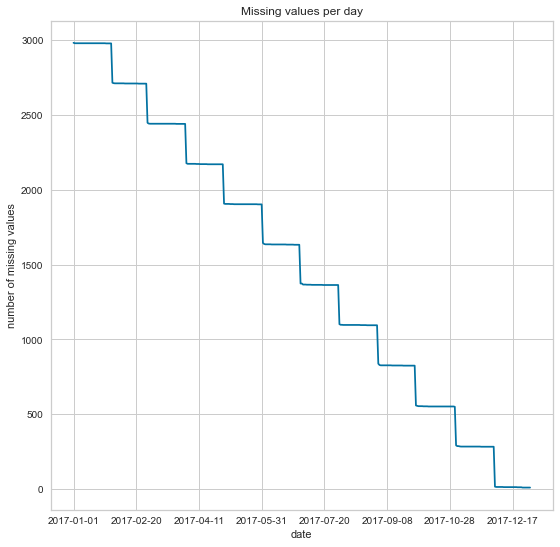

In [5]:
# plotting number of missing values
nan_count.plot(figsize=(9,9), title="Missing values per day", xlabel="date", ylabel="number of missing values")

#### Conclusions:
* We now know that the exists no single day where all meters have a reading
* The best we can get is a minimum of 11 missing values per day for the last 6 days of the year
    * This is likely as the battery in the meter has died.
* For the last 28 days we only have 21 different meters we are missing values for
* Before that it goes up exponentially making it impractical to use any more days than the last 28
    
* Plan is to:
    1. Create new dataframe of just the last 28 days
    2. Fill the missing values for the 15 that contain missing to 0
    3. Cluster the dataframe
    
* Questions are:
    * 1. just because they have similar patterns in december, are they likely to have similar patterns year round?
        * eg is this enough data to make a real conclusion on
    * 2. is it a good idea as the predicted values may not be accurate
    * 3. May also still have an issue with the onehot encoding if one cluster has too many assigned meters
        * so may be forced to use a different model
        * could maybe get around this with a keras embedding layer
        
# 1. Creating new dataframe of just the last 29 days 

In [ ]:
# last 29 days have most reasonable amount of missing values
df_energy_last_29 = pd.concat([pd.DataFrame(df_energy["meter_id"]),df_energy.iloc[:,-29:]], axis=1)
df_energy_last_29

In [ ]:
# checking the number of missing values
df_energy_last_29.isnull().sum(axis = 0)

In [ ]:
df_energy_last_29=df_energy_last_29.fillna(0) # now filling the missing values with 0

# 2. Clustering the dataframe
## Getting optimal euclidean K value via elbow

* Euclidean distance : not particularly adapted for time series

In [ ]:
# elbow method for getting best value for k
# https://www.scikit-yb.org/en/latest/api/cluster/elbow.html
if not os.path.exists(f"../EDA/plots/consumption/clustering/euclidean/"):
    os.makedirs(f"../EDA/plots/consumption/clustering/euclidean/")


clusterer = TimeSeriesKMeans()
visualizer = KElbowVisualizer(clusterer, k=(1,25))

visualizer.fit(df_energy_last_29.drop("meter_id", axis=1))
plt.title("TimeSeries kMeans Elbow")
plt.savefig("../EDA/plots/consumption/Clustering/euclidean/_elbow.png")
visualizer.show()

In [ ]:
# k value (how many clusters)
k = 5

## Clustering via euclidean kmeans

In [ ]:
#fitting the euclidean kmeans
clusterer = TimeSeriesKMeans(n_clusters=k)
clusterer.fit(df_energy_last_29.drop("meter_id", axis=1))

In [ ]:
# getting the centroids
centroids = clusterer.cluster_centers_

In [ ]:
#predicting which meters belong to which cluster
labels_euc = clusterer.predict(df_energy_last_29.drop("meter_id",axis=1))
labels_euc


In [ ]:
#adding the labels to the dataframe for ease of plotting
df_energy_29_labels = df_energy_last_29
df_energy_29_labels["labels"]=labels_euc
df_energy_29_labels

In [ ]:
if not os.path.exists(f"../EDA/plots/consumption/clustering/euclidean/{k}/"):
    os.makedirs(f"../EDA/plots/consumption/clustering/euclidean/{k}/")

# plotting the assigned points ontop of the centroids
for i in tqdm(np.unique(labels_euc)):
    plt.figure(figsize=(10,5))
    plt.title("Euclidean centroid "+str(i+1)+" of "+str(k)+" assignments")
    plt.xlabel("Date")
    plt.ylabel("Energy usage")
    plt.locator_params(axis='x', nbins=10)
    for j in tqdm(range(len(df_energy_29_labels.drop("meter_id",axis=1))), leave=False):
        if(df_energy_last_29.drop("meter_id",axis=1).iloc[j].labels==i):
            plt.plot(df_energy_last_29.drop("meter_id",axis=1).iloc[j].T, color="blue",lw=0.5, label="assigned")
    plt.plot(centroids[i], color="red",lw=3, label="centroid",ls="dashed")
    plt.savefig(f"../EDA/plots/consumption/clustering/euclidean/{k}/cluster_{i}")
    plt.show()
    plt.close()

In [ ]:
# joining based on meter_id to assign labels to the original dataset (with all meter readings)
df_energy_labels = pd.merge(df_energy, df_energy_29_labels[{"meter_id","labels"}], on="meter_id",how="inner")
df_energy_labels

In [ ]:
# plotting all the assigned data on top of each other
# last 29 days

colours = ["red","blue","green","magenta","cyan","orange","brown","grey","pink","purple","black","olive"]

plt.figure(figsize=(15,15))
plt.title("last 29 days clusters")
plt.xlabel("Date")
plt.ylabel("Energy usage")
plt.locator_params(axis='x', nbins=10)

for i in tqdm(np.unique(labels_euc)):

    
    #plotting the one with no missing nans in december
    for j in tqdm(range(len(df_energy_29_labels.drop("meter_id",axis=1).drop("labels",axis=1))), leave=False):
        if(df_energy_29_labels.drop("meter_id",axis=1).iloc[j].labels==i):
            plt.plot(df_energy_29_labels.drop("meter_id",axis=1).drop("labels",axis=1).fillna(0).iloc[j].T, color=colours[i],lw=0.5)

plt.savefig(f"../EDA/plots/consumption/clustering/euclidean/{k}/clusters_last_29_ts.png")
plt.show()
plt.close()

In [ ]:
# plotting all the assigned data on top of each other
# all data

colours = ["red","blue","green","magenta","cyan","orange","brown","grey","pink","purple","black","olive"]

plt.figure(figsize=(15,15))
plt.title("year long clusters")
plt.xlabel("Date")
plt.ylabel("Energy usage")
plt.locator_params(axis='x', nbins=10)

for i in tqdm(np.unique(labels_euc)):

    
    #plotting the one with no missing nans in december
    for j in tqdm(range(len(df_energy_labels.drop("meter_id",axis=1).drop("labels",axis=1))), leave=False):
        if(df_energy_labels.drop("meter_id",axis=1).iloc[j].labels==i):
            plt.plot(df_energy_labels.drop("meter_id",axis=1).drop("labels",axis=1).fillna(0).iloc[j].T, color=colours[i],lw=0.5)

plt.savefig(f"../EDA/plots/consumption/clustering/euclidean/{k}/clusters_all_ts.png")
plt.show()
plt.close()

## Clustering the data via dba kmeans

* adaption of dtw using averages to be faster and more accurate

### Using the elbow method to find the best value for k for dba

In [ ]:
# elbow method for getting best value for k
# https://www.scikit-yb.org/en/latest/api/cluster/elbow.html
if not os.path.exists(f"../EDA/plots/consumption/clustering/dba/"):
    os.makedirs(f"../EDA/plots/consumption/clustering/dba/")


clusterer = TimeSeriesKMeans(n_init=2, metric="dtw", max_iter_barycenter=10)
visualizer = KElbowVisualizer(clusterer, k=(1,25))

visualizer.fit(df_energy_last_29.drop("meter_id", axis=1))
plt.title("DBA kMeans Elbow")
plt.savefig("../EDA/plots/consumption/Clustering/dba/_elbow.png")
visualizer.show()

In [ ]:
# k value (how many clusters)
k = 6

### Running DBA kMeans to cluster the data using the optimal k elbow

In [ ]:
#fitting the dba kmeans
clusterer = TimeSeriesKMeans(n_clusters=k, n_init=2, metric="dtw", max_iter_barycenter=10)
clusterer.fit(df_energy_last_29.drop("meter_id", axis=1))

In [ ]:
# getting the centroids
centroids = clusterer.cluster_centers_

In [ ]:
#predicting which meters belong to which cluster
labels_dba = clusterer.predict(df_energy_last_29.drop("meter_id",axis=1))
labels_dba


In [ ]:
#adding the labels to the dataframe for ease of plotting
df_energy_29_labels = df_energy_last_29
df_energy_29_labels["labels"]=labels_dba
df_energy_29_labels

In [ ]:
if not os.path.exists(f"../EDA/plots/consumption/clustering/dba/{k}/"):
    os.makedirs(f"../EDA/plots/consumption/clustering/dba/{k}/")


# plotting the assigned points ontop of the centroids
for i in tqdm(np.unique(labels_dba)):
    plt.figure(figsize=(10,5))
    plt.title("DBA centroid "+str(i+1)+" of "+str(k)+" assignments")
    plt.xlabel("Date")
    plt.ylabel("Energy usage")
    plt.locator_params(axis='x', nbins=10)
    for j in tqdm(range(len(df_energy_29_labels.drop("meter_id",axis=1))), leave=False):
        if(df_energy_last_29.drop("meter_id",axis=1).iloc[j].labels==i):
            plt.plot(df_energy_last_29.drop("meter_id",axis=1).iloc[j].T, color="blue",lw=0.5, label="assigned")
    plt.plot(centroids[i], color="red",lw=3, label="centroid", ls="dashed")
    plt.savefig(f"../EDA/plots/consumption/clustering/dba/{k}/cluster_{i}")
    plt.show()
    plt.close()

In [ ]:
# joining based on meter_id to assign labels to the original dataset (with all meter readings)
df_energy_labels = pd.merge(df_energy, df_energy_29_labels[{"meter_id","labels"}], on="meter_id",how="inner")
df_energy_labels

In [ ]:
# plotting all the assigned data on top of each other
# last 29 days

colours = ["red","blue","green","magenta","cyan","orange","brown","grey","pink","purple","black","olive"]

plt.figure(figsize=(15,15))
plt.title("last 29 days clusters")
plt.xlabel("Date")
plt.ylabel("Energy usage")
plt.locator_params(axis='x', nbins=10)

for i in tqdm(np.unique(labels_dba)):

    
    #plotting the one with no missing nans in december
    for j in tqdm(range(len(df_energy_29_labels.drop("meter_id",axis=1).drop("labels",axis=1))), leave=False):
        if(df_energy_29_labels.drop("meter_id",axis=1).iloc[j].labels==i):
            plt.plot(df_energy_29_labels.drop("meter_id",axis=1).drop("labels",axis=1).fillna(0).iloc[j].T, color=colours[i],lw=0.5)

plt.savefig(f"../EDA/plots/consumption/clustering/dba/{k}/clusters_last_29_ts.png")
plt.show()
plt.close()

In [ ]:
# plotting all the assigned data on top of each other
# all data

colours = ["red","blue","green","magenta","cyan","orange","brown","grey","pink","purple","black","olive"]

plt.figure(figsize=(15,15))
plt.title("year long clusters")
plt.xlabel("Date")
plt.ylabel("Energy usage")
plt.locator_params(axis='x', nbins=10)

for i in tqdm(np.unique(labels_dba)):

    
    #plotting the one with no missing nans in december
    for j in tqdm(range(len(df_energy_labels.drop("meter_id",axis=1).drop("labels",axis=1))), leave=False):
        if(df_energy_labels.drop("meter_id",axis=1).iloc[j].labels==i):
            plt.plot(df_energy_labels.drop("meter_id",axis=1).drop("labels",axis=1).fillna(0).iloc[j].T, color=colours[i],lw=0.5)

plt.savefig(f"../EDA/plots/consumption/clustering/dba/{k}/clusters_all_ts.png")
plt.show()
plt.close()

## Clustering the data via soft dtw kmeans

* soft-dtw; slow and less accurate than dba

### Finding elbow of soft-dtw

In [ ]:
# elbow method for getting best value for k
# https://www.scikit-yb.org/en/latest/api/cluster/elbow.html
if not os.path.exists(f"../EDA/plots/consumption/clustering/soft-dtw/"):
    os.makedirs(f"../EDA/plots/consumption/clustering/soft-dtw/")

clusterer = TimeSeriesKMeans(metric="softdtw", metric_params={"gamma":0.01})
visualizer = KElbowVisualizer(clusterer, k=(1,25))

visualizer.fit(df_energy_last_29.drop("meter_id", axis=1))
plt.title("soft-dtw kMeans Elbow")
plt.savefig("../EDA/plots/consumption/Clustering/soft-dtw/_elbow.png")
visualizer.show()

In [ ]:
# k value (how many clusters)
k = 5

### Running soft-dtw kmeans on the optimal k value

In [ ]:
#fitting the soft-dtw kmeans
clusterer = TimeSeriesKMeans(n_clusters=k, metric="softdtw", metric_params={"gamma":0.01})
clusterer.fit(df_energy_last_29.drop("meter_id", axis=1))

In [ ]:
# getting the centroids
centroids = clusterer.cluster_centers_

In [ ]:
#predicting which meters belong to which cluster
labels_dtw = clusterer.predict(df_energy_last_29.drop("meter_id",axis=1))
labels_dtw


In [ ]:
#adding the labels to the dataframe for ease of plotting
df_energy_29_labels = df_energy_last_29
df_energy_29_labels["labels"]=labels_dtw
df_energy_29_labels

In [ ]:
if not os.path.exists(f"../EDA/plots/consumption/clustering/soft-dtw/{k}/"):
    os.makedirs(f"../EDA/plots/consumption/clustering/soft-dtw/{k}/")

# plotting the assigned points ontop of the centroids
for i in tqdm(np.unique(labels_dtw)):
    plt.figure(figsize=(10,5))
    plt.title("soft-dtw centroid "+str(i+1)+" of "+str(k)+" assignments")
    plt.xlabel("Date")
    plt.ylabel("Energy usage")
    plt.locator_params(axis='x', nbins=10)
    for j in tqdm(range(len(df_energy_29_labels.drop("meter_id",axis=1))), leave=False):
        if(df_energy_last_29.drop("meter_id",axis=1).iloc[j].labels==i):
            plt.plot(df_energy_last_29.drop("meter_id",axis=1).iloc[j].T, color="blue",lw=0.5, label="assigned")
    plt.plot(centroids[i], color="red",lw=3, label="centroid",ls="dashed")
    plt.savefig(f"../EDA/plots/consumption/clustering/soft-dtw/{k}/cluster_{i}")
    plt.show()
    plt.close()

In [ ]:
# joining based on meter_id to assign labels to the original dataset (with all meter readings)
df_energy_labels = pd.merge(df_energy, df_energy_29_labels[{"meter_id","labels"}], on="meter_id",how="inner")
df_energy_labels

In [ ]:
# plotting all the assigned data on top of each other
# last 29 days

colours = ["red","blue","green","magenta","cyan","orange","brown","grey","pink","purple","black","olive"]

plt.figure(figsize=(15,15))
plt.title("last 29 days clusters")
plt.xlabel("Date")
plt.ylabel("Energy usage")
plt.locator_params(axis='x', nbins=10)

for i in tqdm(np.unique(labels_dtw)):

    
    #plotting the one with no missing nans in december
    for j in tqdm(range(len(df_energy_29_labels.drop("meter_id",axis=1).drop("labels",axis=1))), leave=False):
        if(df_energy_29_labels.drop("meter_id",axis=1).iloc[j].labels==i):
            plt.plot(df_energy_29_labels.drop("meter_id",axis=1).drop("labels",axis=1).fillna(0).iloc[j].T, color=colours[i],lw=0.5)

plt.savefig(f"../EDA/plots/consumption/clustering/soft-dtw/{k}/clusters_last_29_ts.png")
plt.show()
plt.close()

In [ ]:
# plotting all the assigned data on top of each other
# all data

colours = ["red","blue","green","magenta","cyan","orange","brown","grey","pink","purple","black","olive"]

plt.figure(figsize=(15,15))
plt.title("year long clusters")
plt.xlabel("Date")
plt.ylabel("Energy usage")
plt.locator_params(axis='x', nbins=10)

for i in tqdm(np.unique(labels_dtw)):

    
    #plotting the one with no missing nans in december
    for j in tqdm(range(len(df_energy_labels.drop("meter_id",axis=1).drop("labels",axis=1))), leave=False):
        if(df_energy_labels.drop("meter_id",axis=1).iloc[j].labels==i):
            plt.plot(df_energy_labels.drop("meter_id",axis=1).drop("labels",axis=1).fillna(0).iloc[j].T, color=colours[i],lw=0.5)

plt.savefig(f"../EDA/plots/consumption/clustering/soft-dtw/{k}/clusters_all_ts.png")
plt.show()
plt.close()



# Conclusions:

* DBA gave the best performance out of the 3 tested time series suited kmeans methods
    * Backs up findings from here https://blog.acolyer.org/2016/05/13/dynamic-time-warping-averaging-of-time-series-allows-faster-and-more-accurate-classification/
    
* Hence will use the DBA found classifications
* Will likely use the cluster either to make separate models for each cluster or just as an extra feature for the model to allow it to learn from the clusters

# Saving this data

# TODO : 

* Once elbows are finished
    * rerun code for the differenet kmeans with the optimal k value for each
    
* add labels to the entire dataset
* simply plot each of the clusters of the one with the best distribution error with all the missing nan ones on top then assign them to the one they best fit

In [ ]:
#adding the labels to the dataframe for ease of plotting
df_energy_29_labels = df_energy_last_29
df_energy_29_labels["labels"]=labels_dba
# joining based on meter_id to assign labels to the original dataset (with all meter readings)
df_energy_labels = pd.merge(df_energy, df_energy_29_labels[{"meter_id","labels"}], on="meter_id",how="inner")
df_energy_labels

In [ ]:
if(os.path.exists(f"../Data/Preprocessed_Data/consumption_clustered.pkl")==False):
        df_energy_labels.to_pickle(f"../Data/Preprocessed_Data/consumption_clustered.pkl")